In [1]:
from firedrake import *
from firedrake.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from firedrake.cython import dmcommon
from firedrake.mesh import plex_from_cell_list

In [2]:
mesh = Mesh("../meshes/ITER.msh", dim = 2, distribution_parameters={"partition": False}, reorder = True)
mesh.init()

In [8]:
# Define a function space as tool to access nodes and cells:
V = FunctionSpace(mesh, "CG", 1)

# Fill "dof_coords" vector with the coordinates of the boundary nodes of the 2D mesh
coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
#dofs = DirichletBC(V_tool, 0.0, 15).nodes
dofs = V.boundary_nodes(15)
dof_coords = coord_func.dat.data_ro[dofs]

In [13]:
facets = mesh.topology.exterior_facets.facets
boundary_cells = mesh.topology.exterior_facets.facet_cell_map.values
print(f'Number of boundary dofs: {len(dofs)}')
print(f'Number of exterior faceta: {len(facets)}')        
print(f'Number of boundary facets: {len(boundary_cells)}')
print(f'Total number of cells: {mesh.topology.num_cells()}')
print(f'Total number of vertices: {mesh.topology.num_vertices()}')
print(f'Total number of dofs: {V.dof_count}')


Number of boundary dofs: 68
Number of exterior faceta: 68
Number of boundary facets: 68
Total number of cells: 5124
Total number of vertices: 2597
Total number of dofs: 2597


In [ ]:
# For each dof in the boundary:
#   - identify the two closest nodes;
#   - introduce one node at distance h/3;
#   - include the two segments in cell.

        # Add a point in the direction i->j at 1/3 distance:
        #new_dof = 2/3*dof_coords[i] + 1/3*dof_coords[k]
        #new_idx = len(dof_coords_list)-1
        #dof_coords_list.append(new_dof.tolist())

In [16]:
def fill_dist_matrix(vect):
    # Fills the distance matrix between points
    n = len(vect)
    dist_matrix = []

    for i in range(n):
        row = [np.zeros(n)]
        for j in range(n):
            row[j] = np.linalg.norm(vect[i]-vect[j])
        row[i] = np.inf
        dist_matrix.append(row)

    return dist_matrix

In [14]:
dof_coords = coord_func.dat.data_ro[dofs]

# Fill the segments = cells of the 1D boundary mesh:
n = len(dof_coords)
segments = set()   # format "set" to ignore duplicates

for i in range(n):

    # Compute the distance with the others dofs:
    dist = np.zeros(n)
    for j in range(n):
        dist[j] = np.linalg.norm(dof_coords[i]-dof_coords[j])
    dist[i] = np.inf    # set distance with itself = inf

    # Identify the indexes of the two neighbouring dofs of dof_coords[i]
    neighbour_dofs = np.argsort(dist)[:2]

    for k in neighbour_dofs:
        segments.add(tuple(sorted([i,k])))

# Convert "segments" in array:
segments = np.array(list(segments))


In [55]:
display(len(dof_coords))
display(segments)

68

array([[32, 34],
       [58, 59],
       [18, 20],
       [35, 36],
       [44, 51],
       [50, 61],
       [61, 64],
       [46, 51],
       [ 0,  2],
       [ 8,  9],
       [23, 25],
       [49, 50],
       [40, 47],
       [34, 37],
       [65, 67],
       [17, 18],
       [ 1,  3],
       [19, 21],
       [28, 30],
       [36, 40],
       [45, 52],
       [55, 56],
       [37, 48],
       [16, 19],
       [ 6,  8],
       [15, 17],
       [24, 26],
       [33, 35],
       [41, 42],
       [64, 65],
       [59, 60],
       [ 5,  6],
       [20, 22],
       [29, 31],
       [43, 54],
       [46, 47],
       [14, 15],
       [39, 44],
       [ 0,  1],
       [ 9, 10],
       [ 2,  4],
       [10, 11],
       [11, 13],
       [13, 16],
       [30, 32],
       [63, 66],
       [ 7, 12],
       [56, 57],
       [25, 27],
       [42, 43],
       [26, 28],
       [ 4,  7],
       [12, 14],
       [ 3,  5],
       [21, 23],
       [41, 53],
       [38, 39],
       [38, 45],
       [22, 24

In [15]:
plex = plex_from_cell_list(1, segments, dof_coords, comm=mesh.comm)
m = Mesh(plex, dim=1, reorder = True)
m.init()

In [31]:
V = FunctionSpace(mesh,"P",1)
Q = FunctionSpace(m, "P", 2)

In [32]:
x,y = SpatialCoordinate(m)
f = Function(Q).interpolate(x**2+y**2)

In [30]:
display(f.dat.data_ro[:])

array([4.00010000e+00, 1.00010000e+00, 1.00000000e-04, 9.00010000e+00,
       1.00010000e+00, 1.60001000e+01, 4.00010000e+00, 2.50001000e+01,
       9.00010000e+00, 3.60001000e+01, 1.60001000e+01, 4.90001000e+01,
       2.50001000e+01, 6.40001000e+01, 3.60001000e+01, 8.10001000e+01,
       4.90001000e+01, 1.00000100e+02, 6.40001000e+01, 1.01018658e+02,
       8.10001000e+01, 1.04034359e+02, 1.00000100e+02, 1.09047205e+02,
       1.01018658e+02, 1.16057194e+02, 1.04034359e+02, 1.25064327e+02,
       1.09047205e+02, 1.36068604e+02, 1.16057194e+02, 1.49070025e+02,
       1.25064327e+02, 1.64068590e+02, 1.36068604e+02, 1.81064298e+02,
       1.49070025e+02, 2.00057151e+02, 1.64068590e+02, 2.21047147e+02,
       1.81064298e+02, 2.44034288e+02, 2.00057151e+02, 2.69018572e+02,
       2.21047147e+02, 2.96000000e+02, 2.44034288e+02, 2.77000000e+02,
       2.69018572e+02, 2.60000000e+02, 2.96000000e+02, 2.45000000e+02,
       2.77000000e+02, 2.32000000e+02, 2.60000000e+02, 2.21000000e+02,
      

In [ ]:
coord_func = Function(VectorFunctionSpace(Q.mesh(), "CG", 1)).interpolate(as_vector(SpatialCoordinate(Q.mesh())))
nodes_coords = coord_func.dat.data_ro[:]
dof_coords = Q.tabulate.dof_coordinates


AttributeError: 'FunctionSpace' object has no attribute 'degrees_of_freedom'

In [34]:
for i in range(len(dof_coords)):
    display(dof_coords[i][0]**2 + dof_coords[i][1]**2 - f.dat.data_ro[i])

1.750000000015914

-3.000000000030873

-1.00000000002705

8.750000000055163

0.9999999999778879

9.750000000000547

-5.00000000010738

24.750000000060993

7.999999999970573

23.749999999952525

-1.2397904924910108e-10

46.75000000001061

20.99999999997806

43.7499999999017

10.999999999891998

74.75000000002385

40.00000000000016

69.74999999996339

27.999999999940115

88.76855765312455

65.00000000003686

61.784259183686416

51.00000000002071

88.79710459194749

76.01855765311821

59.8070938776692

40.03425918369655

94.81422704098912

73.04710459185262

63.818504081870685

35.05709387749167

106.81992500033758

76.06422704073867

73.81848979620227

36.06850408144115

124.81419846969072

85.0699249997705

99.79741517879675

63.04993214258731

148.79704744919195

100.06419846922014

141.75742232149955

96.02279183650981

178.76847193887102

121.04704744880516

189.7088610969088

134.9870831631348

176.74026415814234

167.9999142856256

147.69744374989284

179.9428061223604

142.7231345662845

172.96564081632076

111.68888252535119

134.935672959032

114.70886109690561

135.95279540818535

81.68317742325414

95.9313959181815

92.6974437500091

104.94280612257982

57.68032844359544

62.929974999783184

76.688882525592

79.93567295938077

39.68033558645607

35.93141020386736

66.68317742365517

In [10]:
x,y = SpatialCoordinate(mesh)
f_2D = Function(V).interpolate(y)

# Interpolation on boundary mesh:
f_1D = Function(Q)
boundary_nodes = DirichletBC(V_tool, 0.0, "on_boundary").nodes
f_1D.dat.data[:] = f_2D.dat.data_ro[boundary_nodes]


In [11]:
f_1D.dat.data[:]

array([ 1.0000000e+01,  1.0000000e+01,  1.0000000e+01,  1.0000000e+01,
        1.0000000e+01,  1.0000000e+01,  1.0000000e+01,  1.0000000e+01,
        1.0000000e+01,  1.0000000e+01,  1.0000000e+01,  9.0000000e+00,
        1.0000000e+01,  8.0000000e+00,  1.0000000e+01,  1.0000000e+01,
        7.0000000e+00,  1.0000000e+01,  9.0000000e+00,  6.0000000e+00,
        8.0000000e+00,  5.0000000e+00,  7.0000000e+00,  4.0000000e+00,
        6.0000000e+00,  3.0000000e+00,  5.0000000e+00,  2.0000000e+00,
        4.0000000e+00,  1.0000000e+00,  3.0000000e+00, -1.2290613e-11,
        2.0000000e+00, -1.0000000e+00,  1.0000000e+00, -2.0000000e+00,
       -3.0000000e+00,  1.2290613e-11, -1.0000000e+01, -9.0000000e+00,
       -4.0000000e+00, -9.0000000e+00, -1.0000000e+01, -1.0000000e+01,
       -8.0000000e+00, -1.0000000e+01, -6.0000000e+00, -5.0000000e+00,
       -1.0000000e+00, -1.0000000e+01, -1.0000000e+01, -7.0000000e+00,
       -1.0000000e+01, -8.0000000e+00, -1.0000000e+01, -2.0000000e+00,
      

In [14]:
elem = V.ufl_element()
display(elem.family())
display(elem.degree())

Q = FunctionSpace(m, elem.family(), elem.degree())

'Lagrange'

1

### TRY TO DEFINE THE GREEN FUNCTION:

In [18]:
def G_eval(xr,xz,yr,yz):
    k2 = 4*xr*yr / ((xr+yr)**2+(xz-yz)**2)
    k = sqrt(k2)
    Kk = special.ellipk(k)
    Ek = special.ellipe(k)
    mu0 * sqrt(xr*yr) / (2*pi*k) * ( (2 - k2)*Kk - 2*Ek )

In [54]:
# Need to extract the dofs of the boundary elements!
boundary_cells = mesh.topology.exterior_facets.facet_cell_map.values    #idx of boundary cells
boundary_cells_nodes = set()

In [29]:
display(len(V.cell_node_map().values[:]))
display(len(V.cell_node_map().values[boundary_cells]))

display(mesh.num_cells())
display(len(boundary_cells))

5124

68

5124

68

In [55]:
# Need to extract the dofs of the boundary elements!
boundary_cells = mesh.topology.exterior_facets.facet_cell_map.values    #idx of boundary cells
V_nodes = set()

for nodes in V.cell_node_map().values[boundary_cells]:      # nodes format of kind: [[i,j,k]]
    #display(nodes)
    for node in nodes[0]:
        V_nodes.add(node)

boundary_cells_nodes = np.array(list(V_nodes))

In [56]:
display(boundary_cells_nodes)
display(len(boundary_cells_nodes))

array([   3,    4,    5, 1031,  520, 1032, 1033, 1034,   13,   18, 1042,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051,   28, 1054, 1055,
        547,   42,   46,   51,  567,  568, 1082, 1083,   61,  576,   69,
         93, 1125,  102,  103, 1126, 1130,  619, 1131, 1132, 1133,  626,
        115,  122,  123,  141,  142,  654,  144,  145,  653, 1169, 1172,
       1171,  155,  165,  684,  177,  700,  189,  706,  707,  206,  215,
        227,  750,  240,  756,  757,  760,  257,  258,  270,  281,  282,
        292,  809,  816,  817,  310,  322,  839,  334,  345,  864,  869,
        361,  888,  894,  382,  896,  895,  899,  901,  394,  920,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  935,  428,
        429,  439,  962,  967,  969,  970,  971,  972,  973,  974,  976,
        977,  469,  486,  998,  999, 1000, 1001, 1002, 1003,  493,  509],
      dtype=int32)

132

In [57]:
# Add also the dofs iin the coils:
coils_tag = [3,4,5,6,7,8,9,10,11,12,13,14]

for tag in coils_tag:
    coil_cells = mesh.cell_subset(tag).indices
    #display(coil_cells)
    for dofs in V.cell_node_map().values[coil_cells]:
        #display(dofs)
        for dof in dofs:    # per qualche motivo ora dofs ha un formato diverso da prima, non devo fare dofs[0]
            V_nodes.add(dof)

V_nodes = np.array(list(V_nodes))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


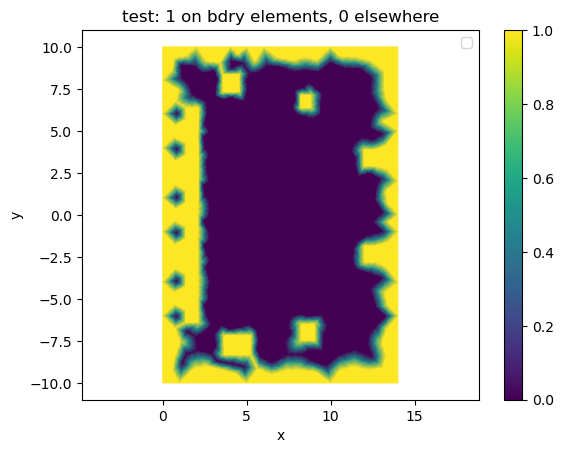

In [58]:
# test -> function which is 0 everywhere and 1 on boundary elements
f = Function(V)
f.dat.data[V_nodes] = 1

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
plt.title(r"test: 1 on bdry elements, 0 elsewhere")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [20]:
from scipy import special
#x,y = SpatialCoordinate(mesh)
mu0 = 4e-7 * pi

V = FunctionSpace(mesh, 'P', 1)
Green = Function(V)
K = Function(V)
V = Function(V)

dof_coords = coord_func.dat.data_ro[:]

# Define G(x,y) with y being a boundary dof:
for idx in dofs:
    X = dof_coords[idx]
    Y = dof_coords[idx]
    Green.dat.data[idx] = G_eval(X[0],X[1],Y[0],Y[1])

In [ ]:
Q = FunctionSpace(m, "DG", 0)